In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler as SS

# import garbage collector
import gc

In [2]:
# read the data
rest = pd.read_csv('michelin restaurants.csv')
housing = pd.read_csv('housing.csv')

In [3]:
print(housing.columns)
print(rest.columns)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
Index(['name', 'year', 'latitude', 'longitude', 'city', 'region', 'zipCode',
       'cuisine', 'price', 'url'],
      dtype='object')


In [4]:
# step 1: prep the data
    # get the range of the california housing map and form a virtual grid of latitude & longitude
    # for each data point
        # get the distance of each data point to a (longitude, latitude) point in the grid, 
            # which will form X: an list of a series of distances
    # turn the price into y, simple
# step 2: feed the data into a neural network
    # we will try to make it similar to the digit recognition
# step 3: evaluate and validate

In [5]:
# get the range of long and lat in housing
house_long_max = np.max(housing['longitude'])
house_long_min = np.min(housing['longitude'])
print(house_long_max, ' ', house_long_min)

# this constant will determine how fine or coarse the mesh/grid is
div = 5

num_long = int((house_long_max - house_long_min)) * div
print(num_long)

house_lat_max = np.max(housing['latitude'])
house_lat_min = np.min(housing['latitude'])
print(house_lat_max, ' ', house_lat_min)

num_lat = int((house_lat_max - house_lat_min)) * div
print(num_lat)

# get the same thing from restaurant
rest_long_max = np.max(rest['longitude'])
rest_long_min = np.min(rest['longitude'])
print(rest_long_max, ' ', rest_long_min)

rest_lat_max = np.max(rest['latitude'])
rest_lat_min = np.min(rest['latitude'])
print(rest_lat_max, ' ', rest_lat_min)

-114.31   -124.35
50
41.95   32.54
45
-117.20013   -123.719444
39.135876   32.939903


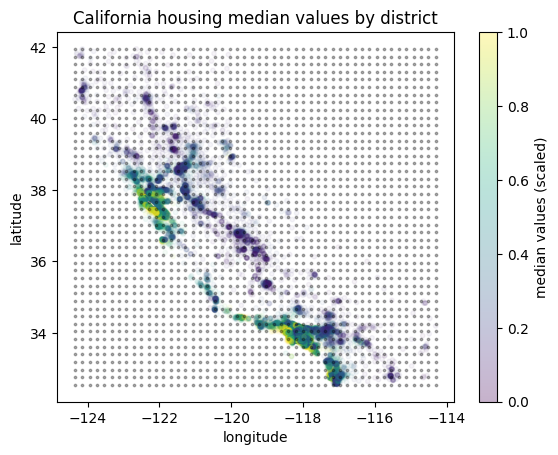

In [6]:
# create a low-resolution grid over california
house_long_lins = np.linspace(house_long_min, house_long_max, num=num_long, endpoint=True)
house_lat_lins = np.linspace(house_lat_min, house_lat_max, num=num_lat, endpoint=True)

long_arr = []
for long in house_long_lins:
    long_arr.append([long for _ in range(num_lat)])
long_grid = np.array(long_arr)
lat_arr = []
for _ in range(num_long):
    lat_arr.append(house_lat_lins)
lat_grid = np.array(lat_arr)

# visualize the grid
plt.scatter(housing['longitude'].to_numpy(), housing['latitude'].to_numpy(), s = 10, c = housing['median_house_value'].to_numpy(), alpha = 0.05)
plt.scatter(long_grid, lat_grid, s = 3, c = 'black', alpha = 0.3)
plt.colorbar().set_label('median values (scaled)')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('California housing median values by district')
plt.show()

In [7]:
# create a loop to get the max and the min as above for a linspace of latitude
house_long = housing['longitude']
house_lat = housing['latitude']
long_ranges = []
for i in range(num_lat-1):
    lrange = house_long[house_lat <= house_lat_lins[i+1]][house_lat >= house_lat_lins[i]]
    ma = lrange.max()
    mi = lrange.min()
    long_ranges.append([mi, ma])

In [8]:
# create some 2d array to put long and lat in, then create a visualized grid
coords = [[], []]
for i in range(num_lat):
    if (i == num_lat-1):
        num = int((long_ranges[i-1][1] - long_ranges[i-1][0])) * div
        long_lins = np.linspace(long_ranges[i-1][0], long_ranges[i-1][1], num=num, endpoint=True)
    else:
        num = int((long_ranges[i][1] - long_ranges[i][0])) * div
        long_lins = np.linspace(long_ranges[i][0], long_ranges[i][1], num=num, endpoint=True)
    for long in long_lins:
        coords[0].append(long)
        coords[1].append(house_lat_lins[i])

print(len(coords[0]))
print(len(coords[1]))
# coords_grid = np.asarray(coords)
print(coords[0][:5])

790
790
[-117.28, -116.9888888888889, -116.69777777777777, -116.40666666666667, -116.11555555555556]


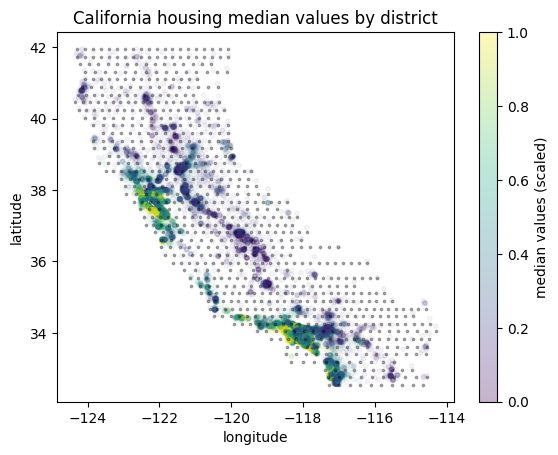

In [9]:
# visualize the grid
plt.scatter(housing['longitude'].to_numpy(), housing['latitude'].to_numpy(), s = 10, c = housing['median_house_value'].to_numpy(), alpha = 0.05)
plt.scatter(coords[0], coords[1], s = 3, c = 'black', alpha = 0.3)
plt.colorbar().set_label('median values (scaled)')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('California housing median values by district')
plt.show()

In [10]:
# this will usually take 6 minutes
input_size = len(coords[0])
print(input_size)

longs = np.array(coords[0])
lats = np.array(coords[1])
X = np.zeros(shape=(len(housing.values), input_size))

for i in range(len(housing.values)):
    dist = ((longs - housing.values[i,0]) ** 2 + (lats - housing.values[i,1]) ** 2) ** 0.5
    X[i] = dist
    del dist
gc.collect()

790


10389

In [11]:
# get the y values and check
y = housing['median_house_value']
print(y.head())

# change the value into np array for training
y = np.array(y)
print(type(X))
print(type(y))

0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
Name: median_house_value, dtype: float64
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [12]:
income = housing['median_income']
X = np.hstack((X, np.atleast_2d(income).T))

In [13]:
# split the stuff to train
X_tr_full, X_te, y_tr_full, y_te = tts(X, y, test_size = 0.2, random_state = 325)
X_tr, X_va, y_tr, y_va = tts(X_tr_full, y_tr_full)

In [14]:
# scale the stuff
std_scaler = SS().fit(X)
Xs_tr = std_scaler.transform(X_tr)
Xs_va = std_scaler.transform(X_va)
Xs_te = std_scaler.transform(X_te)

In [15]:
y_tr = y_tr.reshape(-1,1)
y_va = y_va.reshape(-1,1)
y_te = y_te.reshape(-1,1)
std_scaler = SS().fit(y_tr)
ys_tr = std_scaler.transform(y_tr)
ys_va = std_scaler.transform(y_va)
ys_te = std_scaler.transform(y_te)

In [16]:
from tensorflow import keras

# neural net construction tools
from keras.models import Sequential
from keras.layers import Dense

# training tools
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [19]:
# regression network
housing_net = Sequential([
        Dense(8192, activation = 'relu', input_shape = [X_tr.shape[1]]),
        Dense(1024, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(1)
    ])

housing_net.compile(loss = 'mean_squared_error',
                   optimizer = 'sgd')

In [20]:
# checkpoint: saves model's parameters after each epoch
# earlystop: halts training after validation loss stops improving
# checkpoint = ModelCheckpoint("my_housing_net.h5")
# earlystop = EarlyStopping(patience = 5, restore_best_weights = True)

# train using both tools above
network_history = housing_net.fit(Xs_tr, ys_tr,
                                  epochs = 50,
                                  validation_data = (Xs_va, ys_va))
                                #   callbacks = [checkpoint, earlystop])

Epoch 1/50
387/387 [==============================] - 23s 57ms/step - loss: 0.5887 - val_loss: 0.4031
Epoch 2/50
387/387 [==============================] - 22s 56ms/step - loss: 0.4040 - val_loss: 0.3397
Epoch 3/50
387/387 [==============================] - 22s 56ms/step - loss: 0.3583 - val_loss: 0.3362
Epoch 4/50
387/387 [==============================] - 22s 56ms/step - loss: 0.3393 - val_loss: 0.4769
Epoch 5/50
387/387 [==============================] - 21s 54ms/step - loss: 0.3227 - val_loss: 0.3235
Epoch 6/50
387/387 [==============================] - 20s 52ms/step - loss: 0.3106 - val_loss: 0.3052
Epoch 7/50
387/387 [==============================] - 20s 51ms/step - loss: 0.3061 - val_loss: 0.2896
Epoch 8/50
387/387 [==============================] - 21s 53ms/step - loss: 0.3015 - val_loss: 0.3042
Epoch 9/50
387/387 [==============================] - 21s 55ms/step - loss: 0.2969 - val_loss: 0.2849
Epoch 10/50
387/387 [==============================] - 21s 54ms/step - loss: 0.290

In [ ]:
housing_net.predict(Xs_te[:5])

1/1 [==============================] - 0s 43ms/step


array([[-0.7200086 ],
       [-0.55392957],
       [-0.05457819],
       [ 0.9816635 ],
       [-0.13795155]], dtype=float32)

In [ ]:
ys_te[:5]

array([[-1.0209319 ],
       [-0.64597988],
       [-0.78799404],
       [ 1.82974253],
       [ 1.02095458]])

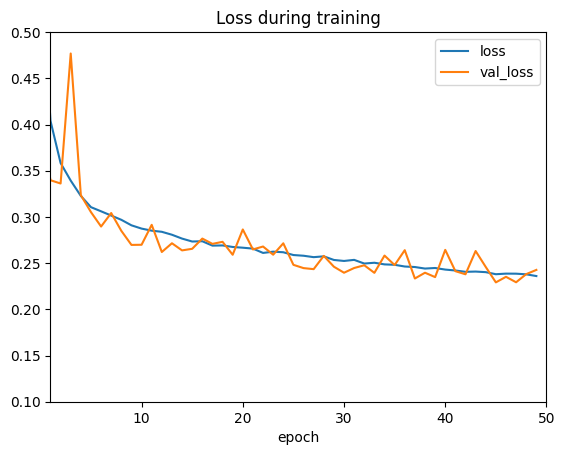

In [22]:
# loss over time: training and validation sets
pd.DataFrame(network_history.history).plot()
plt.xlim([1, 50])
plt.xlabel('epoch')
plt.ylim([0.1, 0.5])
plt.title('Loss during training')
plt.show()

In [23]:
# compare performance of network to linreg and random forest
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import r2_score

ys_tr = ys_tr.reshape(-1)
ys_va = ys_va.reshape(-1)
ys_te = ys_te.reshape(-1)

housing_lin = LR().fit(Xs_tr, ys_tr)
housing_rfr = RFR().fit(Xs_tr, ys_tr)

In [24]:
print('linear regression R^2: ', housing_lin.score(Xs_te, ys_te))
print('forest regression R^2: ', housing_rfr.score(Xs_te, ys_te))

linear regression R^2:  -769526913915.2819
forest regression R^2:  0.8499400327807665


In [25]:
y_pred_net = housing_net.predict(Xs_te).reshape(-1)
print('network regression R^2: ', r2_score(y_pred_net, ys_te))

129/129 [==============================] - 1s 11ms/step
network regression R^2:  0.712471918539381


[-1.02458899 -0.64828089 -0.79080867  1.83639547  1.02468238]


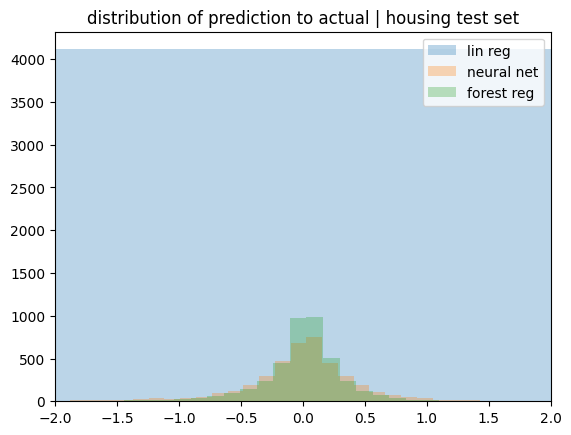

In [26]:
# distribution of prediction delta
# rfr vs network
y_pred_rfr = housing_rfr.predict(Xs_te)
y_pred_lin = housing_lin.predict(Xs_te)
print(ys_te[:5])
num_bins = 50
opac = 0.3

plt.hist(y_pred_lin - ys_te, bins = num_bins, label = 'lin reg', alpha = opac)
plt.hist(y_pred_net - ys_te, bins = num_bins, label = 'neural net', alpha = opac)
plt.hist(y_pred_rfr - ys_te, bins = num_bins, label = 'forest reg', alpha = opac)
plt.title('distribution of prediction to actual | housing test set')
plt.legend()
plt.xlim([-2, 2])
plt.show()

In [27]:
print(y_pred_lin[:5])
print(np.average(y_pred_lin[-5:]))

[-1.02288212 -0.55495562 -0.66125764  1.53823041  0.66576992]
0.08002866348524548


In [44]:
importance = housing_rfr.feature_importances_
# print(importance)
avg = importance.mean()
print(avg)
print((importance > importance.mean()).sum())
im_idx = []
for i, im in enumerate(importance):
    if(im > avg):
        im_idx.append(i)
print(im_idx)
im_coords = [[], []]
for i in im_idx[:-1]:
    im_coords[0].append(coords[0][i])
    im_coords[1].append(coords[1][i])
    print(coords[0][i], " ", coords[1][i])
print(im_coords)

0.0012642225031605564
61
[0, 10, 20, 30, 31, 32, 40, 41, 42, 55, 56, 70, 71, 72, 73, 74, 75, 76, 77, 90, 93, 94, 95, 113, 114, 116, 118, 142, 143, 160, 190, 213, 214, 215, 239, 240, 241, 262, 264, 354, 370, 390, 391, 410, 426, 430, 431, 443, 444, 445, 446, 462, 463, 464, 467, 468, 479, 482, 559, 565, 790]
-117.28   32.54
-117.31   32.75386363636363
-117.38   32.967727272727274
-118.33   33.18159090909091
-118.0111111111111   33.18159090909091
-117.69222222222221   33.18159090909091
-118.48   33.39545454545455
-118.20071428571428   33.39545454545455
-117.92142857142858   33.39545454545455
-118.46   33.60931818181818
-118.18142857142857   33.60931818181818
-118.88   33.823181818181816
-118.64894736842105   33.823181818181816
-118.4178947368421   33.823181818181816
-118.18684210526315   33.823181818181816
-117.9557894736842   33.823181818181816
-117.72473684210526   33.823181818181816
-117.49368421052631   33.823181818181816
-117.26263157894736   33.823181818181816
-119.29   34.0370454545

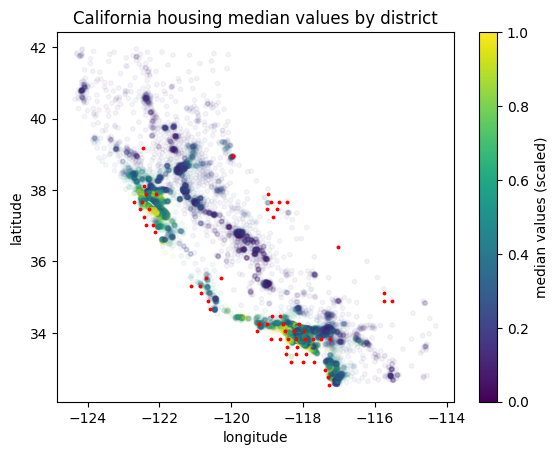

In [48]:
# visualize the grid
plt.scatter(housing['longitude'].to_numpy(), housing['latitude'].to_numpy(), s = 10, c = housing['median_house_value'].to_numpy(), alpha = 0.05)
plt.scatter(im_coords[0], im_coords[1], s = 3, c = 'red', alpha = 1)
plt.colorbar().set_label('median values (scaled)')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('California housing median values by district')
plt.show()

In [49]:
X_new = X[:, im_idx]
# income = housing['median_income']
# X_new = np.hstack((X_new, np.atleast_2d(income).T))
print(X_new.shape)
print(y.shape)

(20640, 61)
(20640,)


In [50]:
# split the stuff to train
X_tr_full, X_te, y_tr_full, y_te = tts(X_new, y, test_size = 0.2, random_state = 325)
X_tr, X_va, y_tr, y_va = tts(X_tr_full, y_tr_full)

In [51]:
# scale the stuff
std_scaler = SS().fit(X_new)
Xs_tr = std_scaler.transform(X_tr)
Xs_va = std_scaler.transform(X_va)
Xs_te = std_scaler.transform(X_te)

In [52]:
y_tr = y_tr.reshape(-1,1)
y_va = y_va.reshape(-1,1)
y_te = y_te.reshape(-1,1)
std_scaler = SS().fit(y_tr)
ys_tr = std_scaler.transform(y_tr)
ys_va = std_scaler.transform(y_va)
ys_te = std_scaler.transform(y_te)

In [53]:
ys_tr = ys_tr.reshape(-1)
ys_te = ys_te.reshape(-1)

housing_rfr = RFR().fit(Xs_tr, ys_tr)
print('forest regression R^2: ', housing_rfr.score(Xs_te, ys_te))

forest regression R^2:  0.843984798599298


In [55]:
scores = []
for n in range(50, 250, 25):
    housing_rfr = RFR(n_estimators=n).fit(Xs_tr, ys_tr)
    s = housing_rfr.score(Xs_te, ys_te)
    scores.append(s)
    print(f'forest regression R^2, {n}: {s}')

forest regression R^2, 50: 0.8425150450560485
forest regression R^2, 75: 0.8439014041767919
forest regression R^2, 100: 0.84409635349646
forest regression R^2, 125: 0.844525942281863
forest regression R^2, 150: 0.8450895650671308
forest regression R^2, 175: 0.8450078564873253
forest regression R^2, 200: 0.8448242249603666
forest regression R^2, 225: 0.8455287828020055


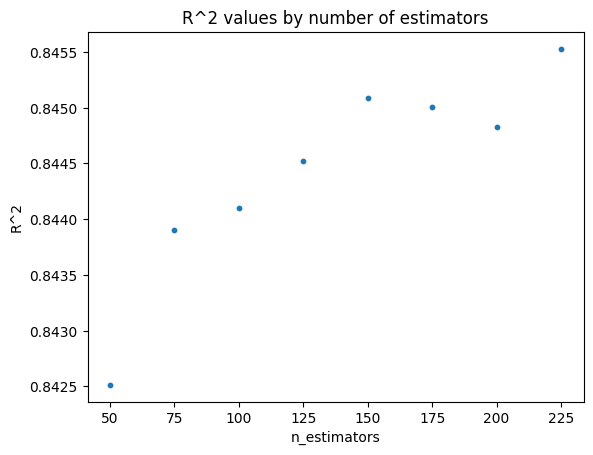

In [58]:
plt.scatter(np.linspace(50, 225, len(scores)), scores, s = 10, alpha = 1)
plt.xlabel('n_estimators')
plt.ylabel('R^2')
plt.title('R^2 values by number of estimators')
plt.show()

In [ ]:
# how to present this thing
# 1. data exploration
#       purpose: to get the idea of the importance of each element to the house price
#       media: graphs of each feature against the house prices
#       correlations between each feature and the house prices
#       content: 
# 2. model building
#       purpose: to have a predicting model for the house prices using existing data
#       content: approach, what is the intuition behind the approach (connect data exploration to this)
#           media: the graphs of the grid over california
#       building step: data prep -> models building -> model pre-evaluation + insights -> models building after insights
#           give clear numbers for each step, for each model, under each div parameter
#           
#           hyper parameter tuning: test each of the hyper parameter set of the model
#           feature selection: use different sets of data
# 3. model evaluation and validation
 